In [6]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./JPG-PNG-to-MNIST-NN-Format-master/', one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/train-labels-idx1-ubyte.gz
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/t10k-images-idx3-ubyte.gz
Extracting ./JPG-PNG-to-MNIST-NN-Format-master/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 16

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 19 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [8]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [9]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [10]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\amita\\AppData\\Local\\Temp\\tmp8r232f9j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000179BF5A7EB8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\amita\AppData\Local\Temp\tmp8r232f9j\model.ckpt.
INFO:tensorflow:loss = 3.0175428, step = 1
INFO:tensorflow:global_step/sec: 38.8776
INFO:tensorflow:loss = 0.06605713, step = 101 (2.574 sec)
INFO:tensorflow:global_step/sec: 48.2509
INFO:tensorflow:loss = 0.020131167, step = 201 (2.072 sec)
INFO:tensorflow:global_step/sec: 45.7624
INFO:tensorflow:loss = 0.0034285057, step = 301 (2.185 sec)
INFO:tensorflow:global_step/sec: 46.3977
INFO:tensorflow:loss = 0.006337652, step = 401 (2.156 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\amita\AppData\Local\Temp\tmp8r232f9j\model.ckpt.
INFO:tensorflow:Loss for final step: 0.016379602.


In [20]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-11-03:19:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\amita\AppData\Local\Temp\tmpijzm4ahh\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-11-03:19:49
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.98269296, global_step = 500, loss = 0.05977647
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\amita\AppData\Local\Temp\tmpijzm4ahh\model.ckpt-500


{'accuracy': 0.98269296, 'loss': 0.05977647, 'global_step': 500}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\amita\AppData\Local\Temp\tmp8r232f9j\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


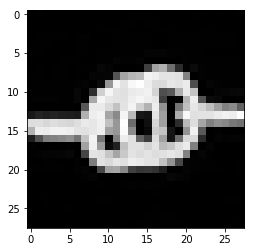

Model prediction: amp_horz


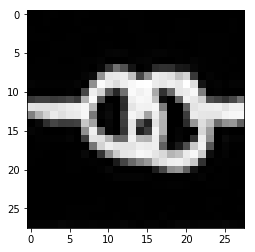

Model prediction: amp_horz


In [13]:
# Predict single images
n_images = 100
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    if preds[i] == 0:
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
        plt.show()
        print("Model prediction:", class_names[preds[i]])

In [12]:
class_names =['amp_horz', 'amp_vert', 'batt_horz_neg', 'batt_horz_pos', 'batt_vert_neg', 'batt_vert_pos', 'cap_horz', 'cap_vert', 'led_horz_neg', 'led_horz_pos', 'led_vert_neg' ,'led_vert_pos', 'res_horz', 'res_vert', 'trans_horz_pos', 'trans_vert_neg', 'trans_vert_pos', 'volt_horz', 'volt_vert']

In [69]:
y_train = mnist.train.labels[:]
y_test = mnist.test.labels[:]
print (y_test)

[12 12  7 ...  8  5  3]


In [28]:
print(max(y_test))

18


In [29]:
print(min(y_test))

0


In [72]:
def display_digit(num):
    print(y_train[num])
    label = y_train[num]
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

7


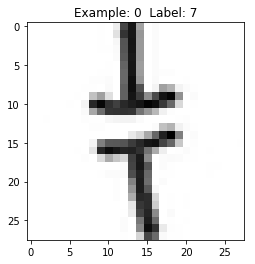

In [91]:
display_digit(0)

In [61]:
import random as ran

In [62]:
def TRAIN_SIZE(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    print('')
    return x_train

def TEST_SIZE(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    return x_test

In [66]:
x_train = TRAIN_SIZE(None)

Total Training Images in Dataset = (1871, 784)
--------------------------------------------------
x_train Examples Loaded = (1871, 784)



In [67]:
x_test = TEST_SIZE(None)

Total Test Examples in Dataset = (2889, 784)
--------------------------------------------------
x_test Examples Loaded = (2889, 784)


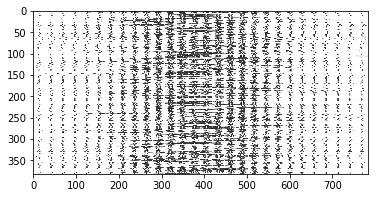

In [80]:
display_mult_flat(18,400)

In [135]:
mnist.test.images[1]

array([0.00392157, 0.        , 0.00392157, 0.        , 0.        ,
       0.        , 0.00392157, 0.00392157, 0.00392157, 0.        ,
       0.00392157, 0.00392157, 0.00392157, 0.00784314, 0.01176471,
       0.00392157, 0.        , 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.        , 0.00392157, 0.00392157, 0.        ,
       0.00392157, 0.        , 0.00784314, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00392157, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00392157, 0.        , 0.        , 0.        , 0.     

In [23]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': np.array([np.asarray(x, dtype=np.float32)])}, shuffle=False) # x is normal array or list of pixel values
# Use the model to predict the images class
preds = list(model.predict(input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\amita\AppData\Local\Temp\tmpijzm4ahh\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [24]:
print(preds)

[7]


In [119]:
print(np.asarray(mnist.test.images[2], dtype=np.float32).shape)

(784,)


In [124]:
x = np.empty([0, 784])

In [139]:
print(x, type(x))

[0.00392157, 0.0, 0.00392157, 0.0, 0.0, 0.0, 0.00392157, 0.00392157, 0.00392157, 0.0, 0.00392157, 0.00392157, 0.00392157, 0.00784314, 0.01176471, 0.00392157, 0.0, 0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.0, 0.00392157, 0.00392157, 0.0, 0.00392157, 0.0, 0.00784314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [25]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': np.array([np.asarray(x, dtype=np.float32)])}, shuffle=False) # x is normal array or list of pixel values
# Use the model to predict the images class
preds = list(model.predict(input_fn))
print(class_names[preds[0]])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\amita\AppData\Local\Temp\tmpijzm4ahh\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
cap_vert


In [11]:
import cv2
import os

oriimg =cv2.imread('./testImg_cap_vert.png', 0)
resized_img = cv2.resize(oriimg,(28, 28))
# inverted_img = cv2.bitwise_not(resized_img)

# cv2.imshow('inverted_img',resized_img)
rows,cols = resized_img.shape
x=[]

for i in range(rows):
    for j in range(cols):
        x.append(resized_img[i,j])

print(len(x))
        
# k = cv2.waitKey(0) & 0xFF
# cv2.destroyAllWindows()

784


In [14]:
def classify(img):
    import cv2

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    resized_img = cv2.resize(img,(28, 28))
    # inverted_img = cv2.bitwise_not(resized_img)
    
    rows,cols = resized_img.shape
    x=[]

    for i in range(rows):
        for j in range(cols):
            x.append(resized_img[i,j])
    
    return get_class(x)

    
def get_class(x):
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': np.array([np.asarray(x, dtype=np.float32)])}, shuffle=False) # x is normal array or list of pixel values
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    
    return class_names[preds[0]] 
    
    # k = cv2.waitKey(0) & 0xFF
    # cv2.destroyAllWindows()

In [15]:
import cv2
import os

oriimg =cv2.imread('./testImg_cap_vert.png',1)

print(classify(oriimg))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\amita\AppData\Local\Temp\tmp8r232f9j\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
cap_vert
